# Generación de texto con una red LSTM
En esta actividad vamos a utilizar una red recurrente LSTM para generar texto.

El corpus que sirve de referencia para generar los textos consiste en Alicia en el País de las Maravillas, aunque se puede utilizar cualquier otro.

El interés de esta actividad es utilizar las redes **LSTM para algo distinto de una clasificación**, aunque, como se puede observar, la calidad de los textos generados es inferior a la que se consigue con otros modelos más actuales, como los transformer.

**Debes completar el código en las secciones indicadas con # COMPLETAR CODIGO**

## Instalación e importación de paquetes

In [ ]:
!pip install progressbar2

In [ ]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import html

import nltk
from nltk import word_tokenize
nltk.download('punkt')
import pickle
import random
import progressbar
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

print(f"use_moses_detokenizer={use_moses_detokenizer}")

use_moses_detokenizer=False


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Definición de parámetros del corpus y su preprocesado

In [ ]:
corpus_url = "https://www.gutenberg.org/cache/epub/11/pg11.txt"
corpus_path = "alicia.txt"
preprocessed_corpus_path = "alicia_preprocessed.p"
most_common_words_number = 10000

## Tranformación entre palabras e índices
Se definen dos funciones:
* **encode_sequence**: codifica una secuencia de palabras en una secuencia de índices
* **decode_indices**: decodifica una secuencia de índices en la secuencia de palabras correspondiente

In [ ]:
def encode_sequence(sequence, vocabulary):

    return [vocabulary.index(element) for element in sequence if element in vocabulary]


def decode_indices(indices, vocabulary):

    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer  == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

## Descarga del corpus
Solo se descarga si no se encuentra en local (Colab o disco)

In [ ]:
import requests

def download_corpus_if_necessary():

    if not os.path.exists(corpus_path):
        print("Descargamos el corpus...")

        # Descargamos el contenido
        corpus_string = requests.get(corpus_url).content.decode('utf-8')

        # Eliminamos etiquetas HTML
        corpus_string = corpus_string.replace("<pre>", "")
        corpus_string = corpus_string.replace("</pre>", "")

        # Grabamos en fichero
        corpus_file = open(corpus_path, "w")
        corpus_file.write(corpus_string)
        corpus_file.close()

        print("El corpus se ha grabado en", corpus_path)
    else:
        print("El corpus ya estaba grabado")

download_corpus_if_necessary()

El corpus ya estaba grabado


## Preprocesado del corpus
Solo se preprocesa si no se ha hecho antes.

In [ ]:
def preprocess_corpus_if_necessary():

    if not os.path.exists(preprocessed_corpus_path):
        print("Preprocesamos el corpus...")

        corpus_file = open(corpus_path, "r")
        corpus_string = corpus_file.read()

        # Generación del vocabulario
        print("Extraemos las palabras (tokens)...")
        corpus_tokens = word_tokenize(corpus_string)
        print("Número de tokens:", len(corpus_tokens))
        print("Generamos el vocabulario...")
        word_counter = Counter()
        word_counter.update(corpus_tokens)
        print("Longitud del vocabulario antes del corte:", len(word_counter))
        vocabulary = [key for key, value in word_counter.most_common(most_common_words_number)]
        print("Longitud del vocabulario después del corte:", len(vocabulary))

        # Conversión a índices
        print("Codificamos a índices...")
        indices = encode_sequence(corpus_tokens, vocabulary)
        print("Número de índices:", len(indices))

        # Saving.
        print("Grabamos fichero de preprocesado del corpus...")
        pickle.dump((indices, vocabulary), open(preprocessed_corpus_path, "wb"))
    else:
        print("El corpus ya estaba preprocesado")

preprocess_corpus_if_necessary()

El corpus ya estaba preprocesado


## Generación del dataset
Enfocamos la generación del dataset como un **aprendizaje auto-supervisado (self-supervised learning)**:
* para generar secuencias de entrada, seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras) del corpus
* para asignar una etiqueta, escogemos el índice de la palabra siguiente a la secuencia de entrada

In [ ]:
# Parámetros de generación del dataset
dataset_size = 50000
sequence_length = 30 # longitud de los textos del dataset de entrenamiento

def get_dataset(indices):

    data_input = []
    data_output = []
    current_size = 0
    bar = progressbar.ProgressBar(max_value=dataset_size)
    while current_size < dataset_size:

        # seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras)
        random_index = random.randint(0, len(indices) - (sequence_length + 1))
        input_sequence = indices[random_index:random_index + sequence_length]
        # la etiqueta de la secuencia aleatoria es el índice de la siguiente palabra
        output_label = indices[random_index + sequence_length]

        data_input.append(input_sequence)
        data_output.append(output_label)

        current_size += 1
        bar.update(current_size)
    bar.finish()

    # Transformamos las listas a numpy arrays
    data_input = np.array(data_input)
    data_output = np.array(data_output)
    return (data_input, data_output)


## Definición de la red LSTM y entrenamiento
Solo se define y entrena si no se ha hecho antes, o si se fuerza con el parámetro train_anyway.

Por último, se graba el modelo.

 68% (34178 of 50000) |############      | Elapsed Time: 0:00:00 ETA:   0:00:00


Generamos el dataset...


100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


Creamos el modelo...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 100)           387100    
                                                                 
 lstm_2 (LSTM)               (None, 1000)              4404000   
                                                                 
 dense_2 (Dense)             (None, 3871)              3874871   
                                                                 
Total params: 8665971 (33.06 MB)
Trainable params: 8665971 (33.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Entrenamos el modelo...
Epoch 1/10
313/313 [==============================] - 28s 80ms/step - loss: 5.9753 - categorical_accuracy: 0.0887 - val_loss: 5.4505 - val_categorical_accuracy: 0.1370
Epoch 2/10
313/313 [==============================] - 17s 53ms/st

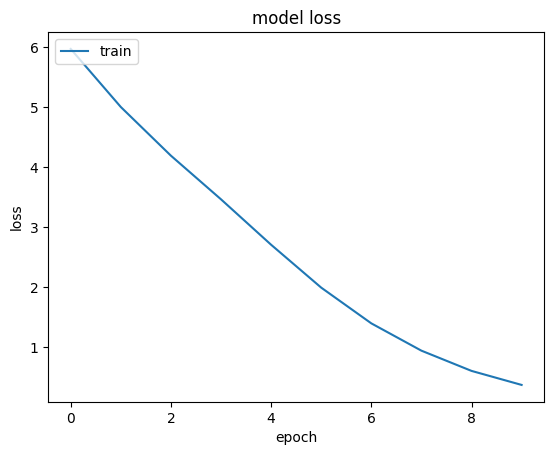

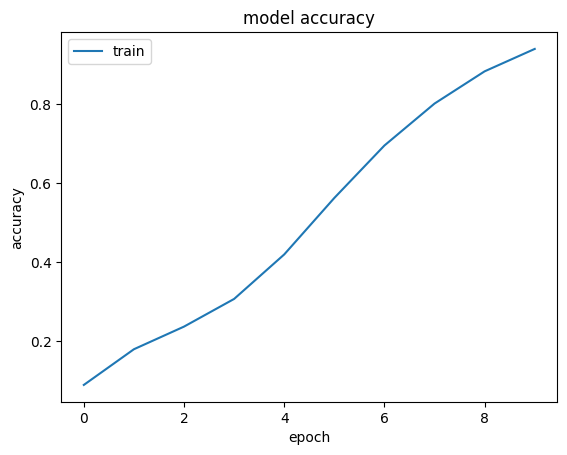

In [ ]:
# Parámetros del modelo y entrenamiento
train_anyway = True # fuerza el entrenamiento, aunque se haya realizado antes
epochs = 10 # número de iteraciones a entrenar
batch_size = 128 # tamaño de lote
hidden_size = 1000 # número de nodos en la red LSTM
embedding_dim = 100 # dimensionalidad de los embeddings
model_path = "alicia_model.h5"

def train_neural_network():

    if not os.path.exists(model_path) or train_anyway == True:

        # Carga de las palabras del corpus y sus índices
        indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

        # Generación del dataset
        print("\nGeneramos el dataset...")
        data_input, data_output = get_dataset(indices)
        data_output = to_categorical(data_output, num_classes=len(vocabulary))

        # Creación del modelo
        print("Creamos el modelo...")
        # COMPLETAR CODIGO (debes seguir las indicaciones de la actividad para generar la red LSTM)
        # Capa de embeddings
        model = Sequential()
        model.add(Embedding(input_dim=len(vocabulary), output_dim=embedding_dim, input_length=data_input.shape[1]))
        # Capa LSTM sencilla
        model.add(LSTM(hidden_size, return_sequences=False))
        # Capa lineal
        model.add(Dense(len(vocabulary), activation='softmax'))
        model.summary()

        # Definimos el resto del modelo: optimizador, función de pérdidas y métrica
        # COMPLETAR CODIGO
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

        # Entrenamiento del modelo
        print("Entrenamos el modelo...")
        # COMPLETAR CODIGO
        history = model.fit(data_input, data_output, epochs=epochs, batch_size=batch_size, validation_split=0.2)

        # Grabación del modelo
        print("...y grabamos el modelo")
        model.save(model_path)

        plot_history(history)


def plot_history(history):

    print(history.history.keys())

    # Gráfica de función de pérdida
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("history_loss.png")
    # plt.clf()
    plt.show()
    plt.close()

    # Gráfica de accuracy.
    plt.plot(history.history['categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("history_accuracy.png")
    # plt.clf()

    plt.show()
    plt.close()

train_neural_network()

La pérdida disminuye de manera consistente a lo largo de las épocas. Esto indica que el modelo está aprendiendo y ajustando sus pesos para minimizar la función de pérdida.

La precisión aumenta de manera constante a lo largo de las épocas, lo cual es una señal positiva de que el modelo está aprendiendo a predecir correctamente las palabras en el corpus.

## Generación de texto

La generación de texto se basa en la función **get_index_from_prediction**, que obtiene un índice a partir de una predicción y un parámetro de temperatura

In [ ]:
# Parámetros de generación de texto
generated_sequence_length = 50 # longitud de los textos generados
n_generated_texts = 15 # número de textos a generar

def generate_texts(n_generated_texts=10):

    print(f"Generamos {n_generated_texts} textos...")

    # carga del corpus
    indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

    # carga del modelo previamente grabado
    model = models.load_model(model_path)

    # Generamos tantos textos como indique el parámetro n_generated_texts
    for _ in range(n_generated_texts):

        # Escogemos un parámetro aleatorio "temperature" para la predicción
        temperature = random.uniform(0.0, 1.0)
        print("Temperatura:", temperature)

        # Obtenemos una muestra aleatoria a modo de secuencia semilla a partir de la cual se generarán textos
        random_index = random.randint(0, len(indices) - (generated_sequence_length))
        input_sequence = indices[random_index:random_index + sequence_length]

        # Generamos la secuenca de salida repitiendo la predicción
        generated_sequence = []
        while len(generated_sequence) < generated_sequence_length:
            prediction = model.predict(np.expand_dims(input_sequence, axis=0))
            predicted_index = get_index_from_prediction(prediction[0], temperature)
            generated_sequence.append(predicted_index)
            input_sequence = input_sequence[1:]
            input_sequence.append(predicted_index)

        # Convertimos la secuencia de índices generada en una frase
        text = decode_indices(generated_sequence, vocabulary)
        print(text)
        print("")


def get_index_from_prediction(prediction, temperature=0.0):

    # Temperatura cero - usamos argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Temperatura distinta de cero - aplicamos cierta aleatoriedad
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate_texts(n_generated_texts)

Generamos 15 textos...
Temperatura: 0.15148483993602713
1/1 [==============================] - 0s 19ms/step
It ’ s the first position in us , ” said the King . “ I ’ ve seen the floor myself , ” said the Mock Turtle : “ crumbs would all my dull of their worm . The never question , in the other solemn as the Foundation

Temperatura: 0.3457610098544741
1/1 [==============================] - 0s 29ms/step
” “ I couldn ’ t the slightest idea , you know. ” “ Not you ? ” said the Mock Turtle in a tone of thunder . “ What are old ? ” said Alice . “ Well , I should know—No it , ” said Alice , who

Temperatura: 0.5117524190809718
1/1 [==============================] - 0s 18ms/step
next ! ” “ I ’ m afraid I don ’ t know , ” said the Caterpillar . “ Well , I shan ’ t ! ” said Alice . “ Well , then ! ” said the Queen : “ you ’ re so no way . But

Temperatura: 0.8571529347502759
1/1 [==============================] - 0s 21ms/step
swallowed down , but rather little sort in cards like the meaning in i

# **Textos Generados y Análisis**

**Temperatura baja (0.0217 - 0.3457):**

**Coherencia:** Estos textos son bastante coherentes y siguen un estilo similar al del texto original. Las oraciones son relativamente lógicas y mantienen una estructura parecida al estilo de "Alicia en el País de las Maravillas".

**Creatividad:** La creatividad es limitada, ya que el modelo sigue de cerca las frases y el vocabulario del texto de entrenamiento. Los resultados son predecibles y similares a las frases del corpus.

**Temperatura media (0.4133 - 0.5118):**

**Coherencia:** Hay una mezcla de coherencia y confusión. Las oraciones comienzan a tener más giros inesperados y combinaciones menos comunes, pero aún así mantienen cierta estructura.

**Creatividad:** La creatividad aumenta, permitiendo frases más inusuales y asociaciones inesperadas. Las ideas empiezan a divergir más del texto original.

**Temperatura alta (0.7804 - 0.9595):**

**Coherencia:** Los textos generados son menos coherentes y pueden parecer fragmentados o absurdos en algunos casos. La conexión entre las oraciones y las ideas es a menudo débil o confusa.

**Creatividad:** La creatividad es alta, con frases y conceptos más extravagantes y originales. El modelo explora combinaciones menos comunes y produce textos que se desvían significativamente del texto original, a menudo con resultados inesperados y surrealistas.

**Ejemplos destacados:**

**Temperatura 0.1515:** It ’ s the first position in us , ” said the King . “ I ’ ve seen the floor myself , ” said the Mock Turtle : “ crumbs would all my dull of their worm . The never question , in the other solemn as the Foundation

Texto coherente y en estilo similar al original, pero un poco repetitivo y rígido.

**Temperatura 0.8572:** swallowed down , but rather little sort in cards like the meaning in it . “ What are your pardoned. ! ” thought Alice . “ That ’ s the thing cat , ” said the Hatter . “ _Un_important ’ s very cat ! ” shouted the King ,

Texto muy creativo pero menos coherente, con ideas y frases inusuales que parecen fuera de contexto.

**Temperatura 0.9069:** children , in any other , in , with the words to listen . She had not a good fee for this off that it had hear it up and were inches high . “ What _can_ first , ” said Alice thoughtfully to herself an important out in the

Texto con una alta dosis de creatividad, pero puede ser difícil de seguir y comprender, con frases que parecen mezcladas o sin sentido claro.


